# Graph2Net Demo

### Import Graph2Net

In [1]:
from graph2net.utils import load_data,gen_and_validate
from graph2net.graph_generators import build_matrix,gen_cell,show_matrix,stack_matrix
from graph2net.ops import print_operations

import numpy as np

### The Model Graph
Graph2Net is built upon the concept of *model graphs*, graphs that defines the data connectivity and operations that occur with a deep-learning model. In such a graph, nodes receive input from their inbound edges, compute the piecewise sum of said inputs, and send this new tensor along its outbound edges. Edges apply functions to tensors, thus transforming the input into output via some operation in the set of operations *O*.

### Operations
Operations define the transformation data flowing along an edge undergoes. The list of operations understood by the graph2net framework are as follows, taken from the [NASNet Search Space](https://arxiv.org/pdf/1707.07012.pdf) with a few additions of my own. The set of operations *O* are as follows:

In [2]:
print_operations()

0 : zero
1 : identity
2 : double_channel
3 : halve_channel
4 : avg_pool_3x3
5 : max_pool_3x3
6 : max_pool_5x5
7 : max_pool_7x7
8 : 1x7_7x1_conv
9 : 1x3_3x1_conv
10 : dil_conv_3x3
11 : conv_1x1
12 : conv_3x3
13 : sep_conv_3x3
14 : sep_conv_5x5
15 : sep_conv_7x7


### Build a Connectivity Matrix
Connectivity matrices are the basis for model definition in Graph2Net. Connect nodes together by operations to specify a model. This can be done via the `build_matrix` function, wherein you can specify a list tuples of `[origin_node,target_node,operation]` or manually via a numpy array.

### Connectivity Matrix Guidelines
In theory, all **strictly upper triangular matrices** (whose nonzero values are integers within the set of *O*), henceforth refered to as SUT matrices, correspond to valid convolutional models. Valid implies that they are runnable, however some may not be *practically* runnable by normal systems.

In [3]:
resnet_from_pairs = build_matrix([
    [0,1,"conv_3x3"],
    [1,2,"conv_3x3"],
    [2,3,"conv_3x3"],
    [3,4,"conv_3x3"],
    [0,2,"identity"],
    [2,4,"identity"],
    [4,5,"max_pool_3x3"],
])
resnet_from_connectivity_matrix = np.array([
    [0, 12,1, 0, 0, 0],
    [0, 0, 12,0, 0, 0],
    [0, 0, 0, 12,1, 0],
    [0, 0, 0, 0, 12,0],
    [0, 0, 0, 0, 0, 5],
    [0, 0, 0, 0, 0, 0]
])

print(np.array_equal(resnet_from_connectivity_matrix,resnet_from_pairs))
resnet=resnet_from_pairs

True


### Model Archetypes
Alternatively, we can import connectivity matrices for some common model archetypes via the `archetypes` module:

In [4]:
from graph2net.archetypes import inception, resNeXt

print("Inception:\n",inception)
print("ResNeXt:\n",resNeXt)

Inception:
 [[ 0. 11. 11.  5. 11.]
 [ 0.  0.  0.  0. 13.]
 [ 0.  0.  0.  0. 14.]
 [ 0.  0.  0.  0. 11.]
 [ 0.  0.  0.  0.  0.]]
ResNeXt:
 [[ 0.  3.  0.  1.]
 [ 0.  0. 13.  0.]
 [ 0.  0.  0.  2.]
 [ 0.  0.  0.  0.]]


### The `show_matrix` function 
`show_matrix` can help elucidate these connectivity matrices; this function simply displays the graph that is described by the connectivity matrices. Here we look at the ResNet connectivity matrix from above, and see what the corresponding graph looks like.

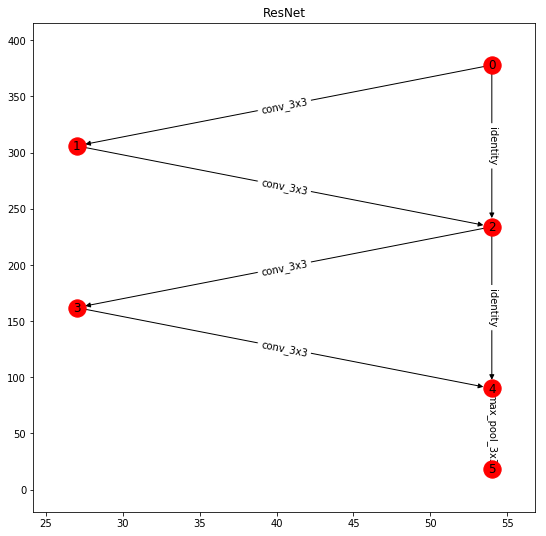

In [5]:
show_matrix(resnet,"ResNet")

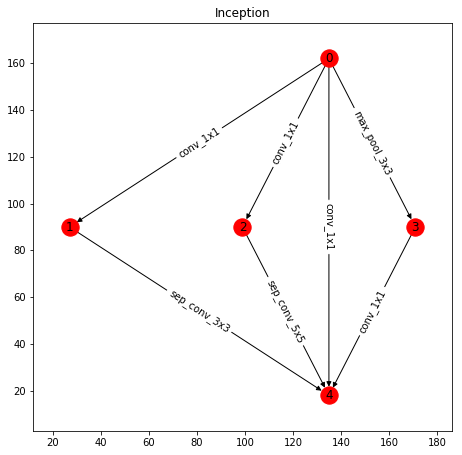

In [6]:
show_matrix(inception,"Inception")

### Cells
The graphs above correspond to a single cell in our final network. Cells are stacked on top of each other to create the final network.

### Viewing the stacked cells
Using the `stack_matrix` function, we can visualize the full network consisting of stacked cells

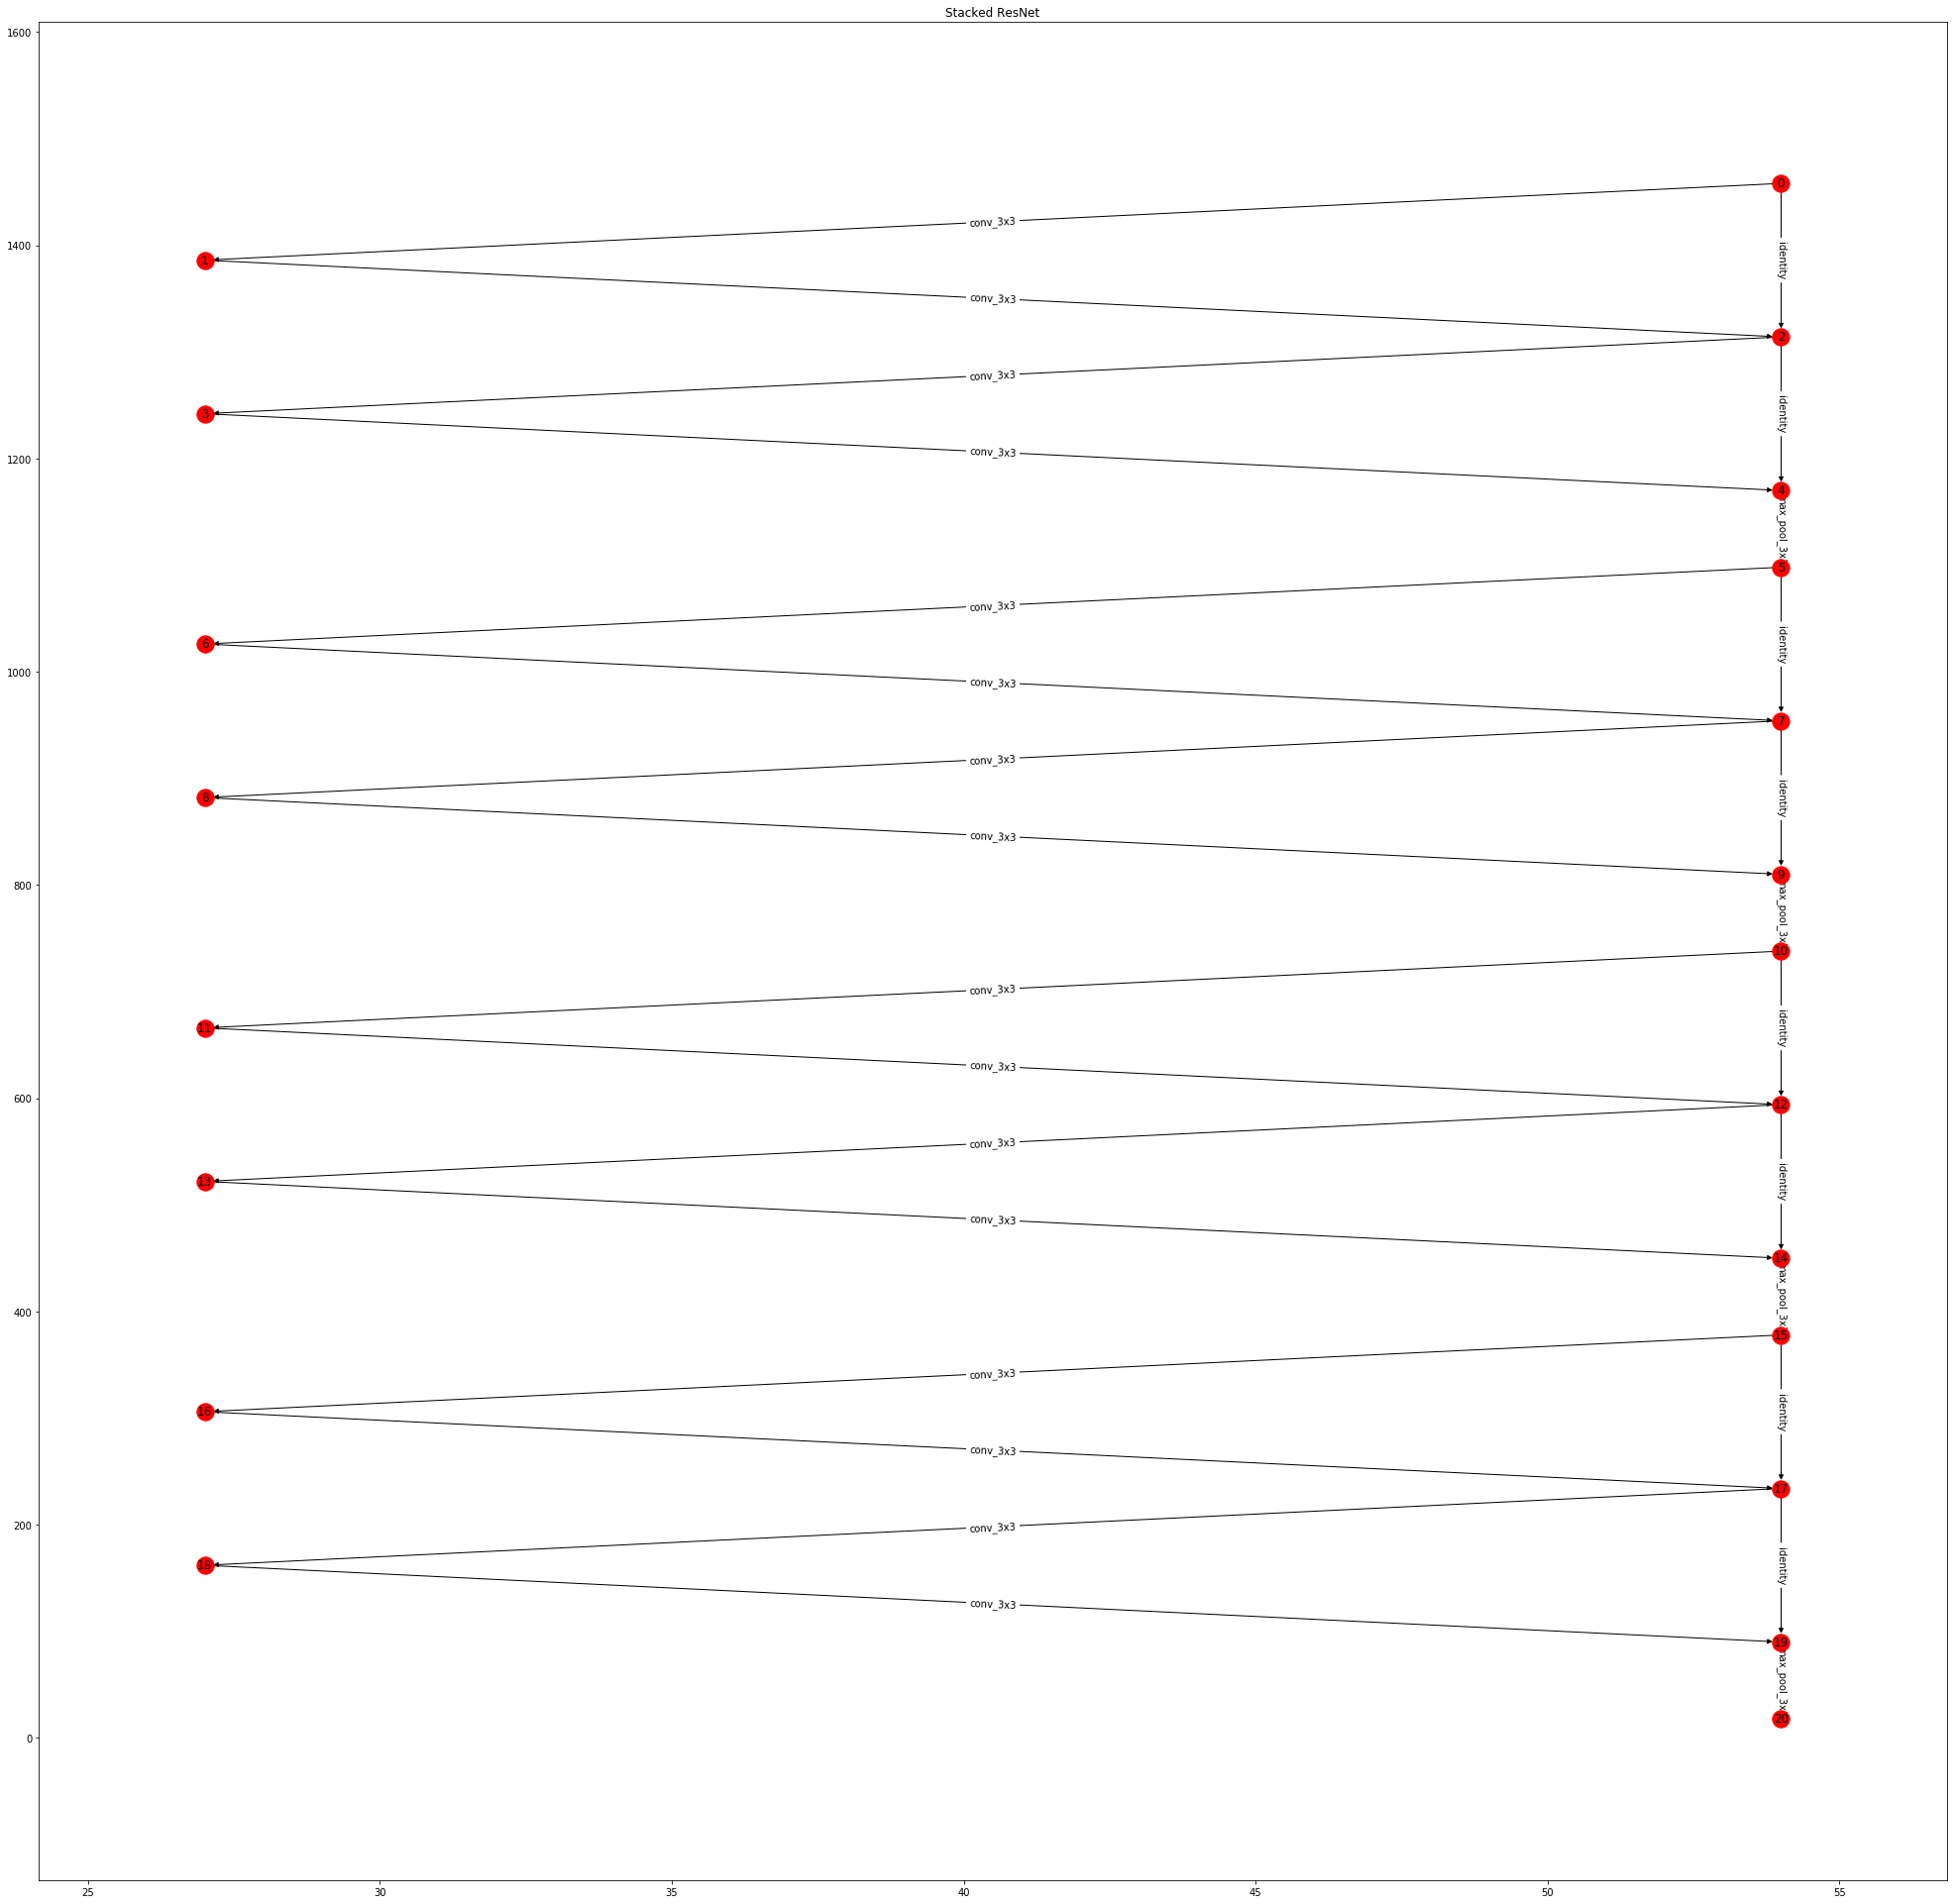

In [7]:
show_matrix(stack_matrix(resnet,4),"Stacked ResNet")

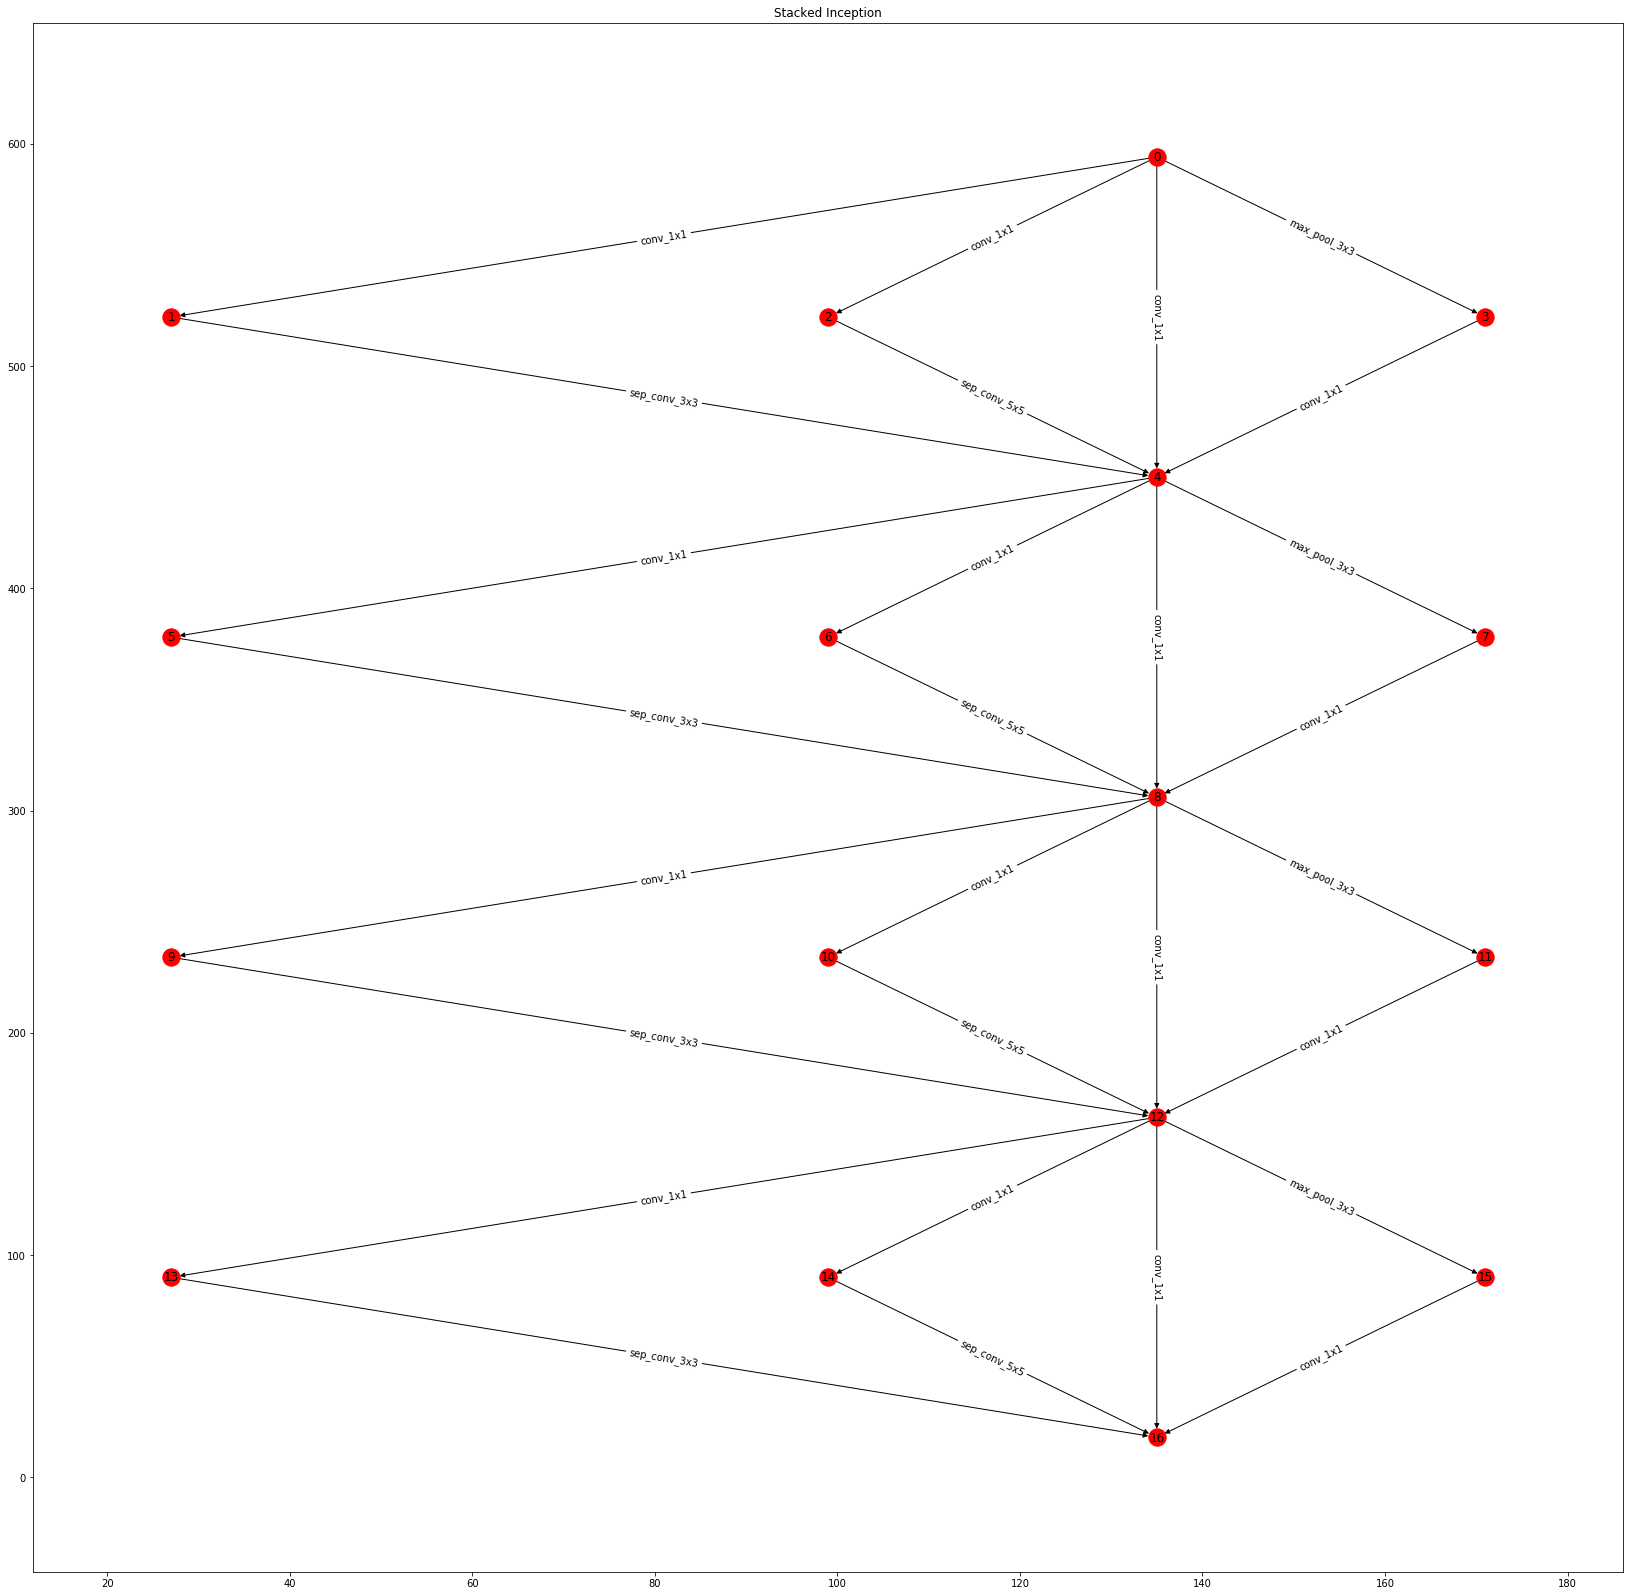

In [8]:
show_matrix(stack_matrix(inception,4),"Stacked Inception")

### Model Validation
To ensure that the specified cell corresponds to a valid network, we use the `gen_and_validate function`. This function takes a connectivity matrix and builds a fully stacked model from said matrix. It then attempts a single batch of training data through and backpropagate the resulting error from this pass through the network. If successful, the function returns a fully useable PyTorch network.

In [9]:
resnet_model    = gen_and_validate(resnet,verbose=False)
inception_model = gen_and_validate(inception,verbose=False)

Validating model...[SUCCESS]
Validating model...[SUCCESS]


In [10]:
print(resnet_model)

================================================== CELL 0 ==================================================
==== Node 0 ====
[64, 3, 32, 32]    -> conv_3x3        (by 1, 3-pad->24-op->24) -> [64, 24, 32, 32]   to Node 1 (360 params)
[64, 3, 32, 32]    -> identity        (by 1, 3-pad->24-op->24) -> [64, 24, 32, 32]   to Node 2 (96 params)
==== Node 1 ====
[64, 24, 32, 32]   -> conv_3x3        (by 1, 24----->24-op->24) -> [64, 24, 32, 32]   to Node 2 (264 params)
==== Node 2 ====
[64, 24, 32, 32]   -> conv_3x3        (by 1, 24----->24-op->24) -> [64, 24, 32, 32]   to Node 3 (264 params)
[64, 24, 32, 32]   -> identity        (by 1, 24----->24-op->24) -> [64, 24, 32, 32]   to Node 4 (0 params)
==== Node 3 ====
[64, 24, 32, 32]   -> conv_3x3        (by 1, 24----->24-op->24) -> [64, 24, 32, 32]   to Node 4 (264 params)
==== Node 4 ====
[64, 24, 32, 32]   -> max_pool_3x3    (by 2, 24----->24-op->24) -> [64, 24, 16, 16]   to Node 5 (0 params)
==== Node 5 ====
[64, 24, 16, 16]   -> out
=======

### Random Cells
Let's test our statement from earlier, that any SUT matrix is a valid convolutional model. We can use the function `gen_cell` to generate random SUT matrices, which takes two inputs: `nodes` and `connectivity`. The `nodes` specifies the number of nodes in the generated cell, while `connectivity` sets the probability that any node *i* is connected to any node *j*. Therefore, a cell with `connectivity=1` will have every node connected to every other node, while a cell with `connectivity=0` will only have the bare minimum connections such that data flows from the input of the cell to the output. See the graphs below for examples.

### Connectivity=1

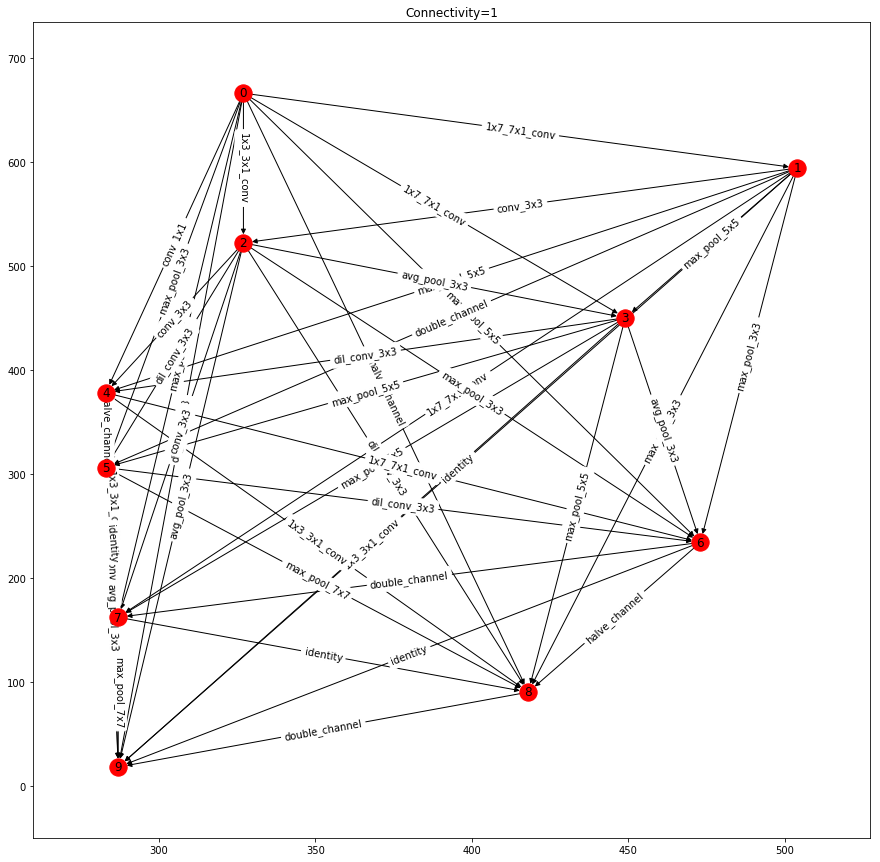

Validating model...[SUCCESS]


In [16]:
c1=gen_cell(nodes=10,connectivity=1)
show_matrix(c1,"Connectivity=1")
p=gen_and_validate(c1,verbose=False,keep_model=False)

### Connectivity=0

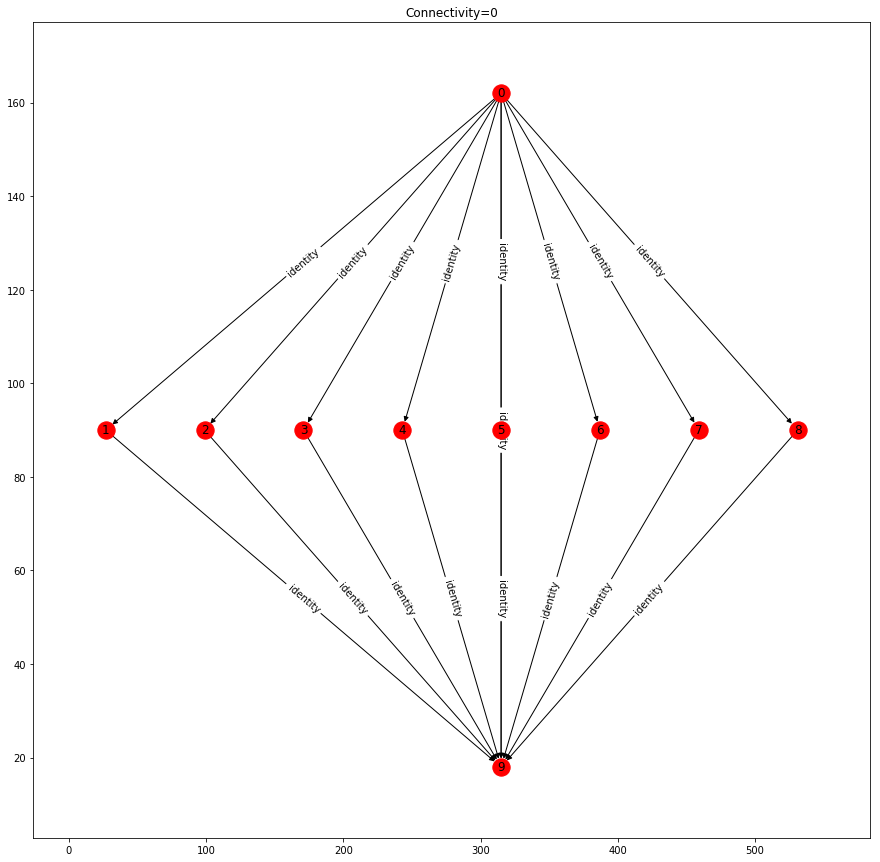

Validating model...[SUCCESS]


In [17]:
c0=gen_cell(nodes=10,connectivity=0)
show_matrix(c0,"Connectivity=0")
p=gen_and_validate(c0,verbose=False,keep_model=False)

### More random cells

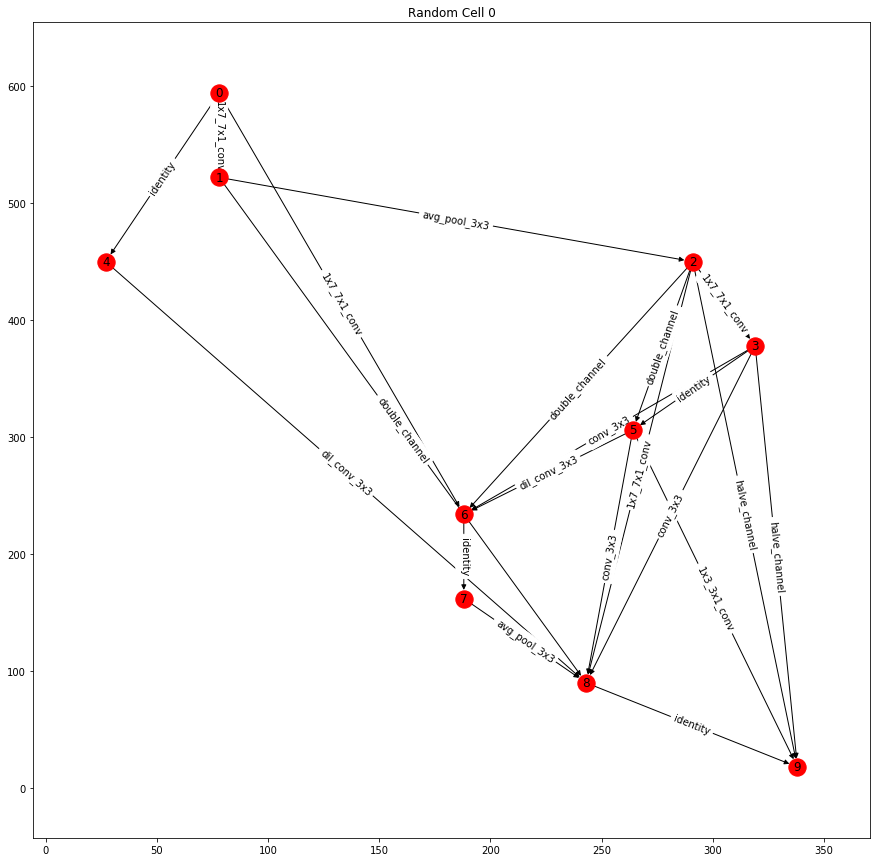

Validating model...[SUCCESS]


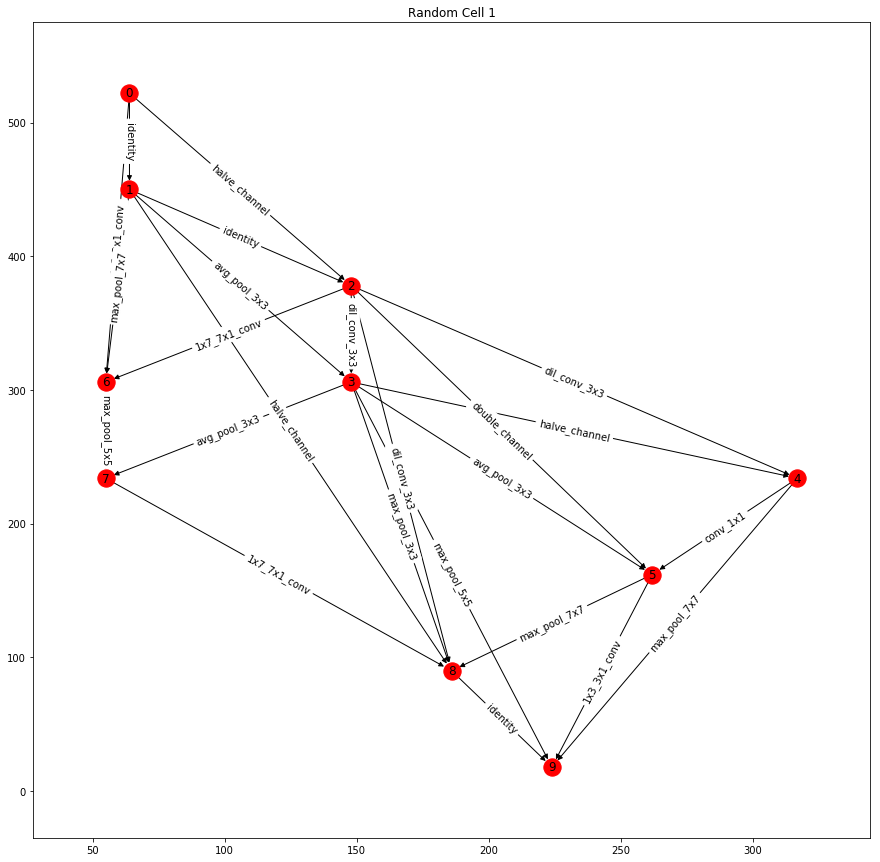

Validating model...[SUCCESS]


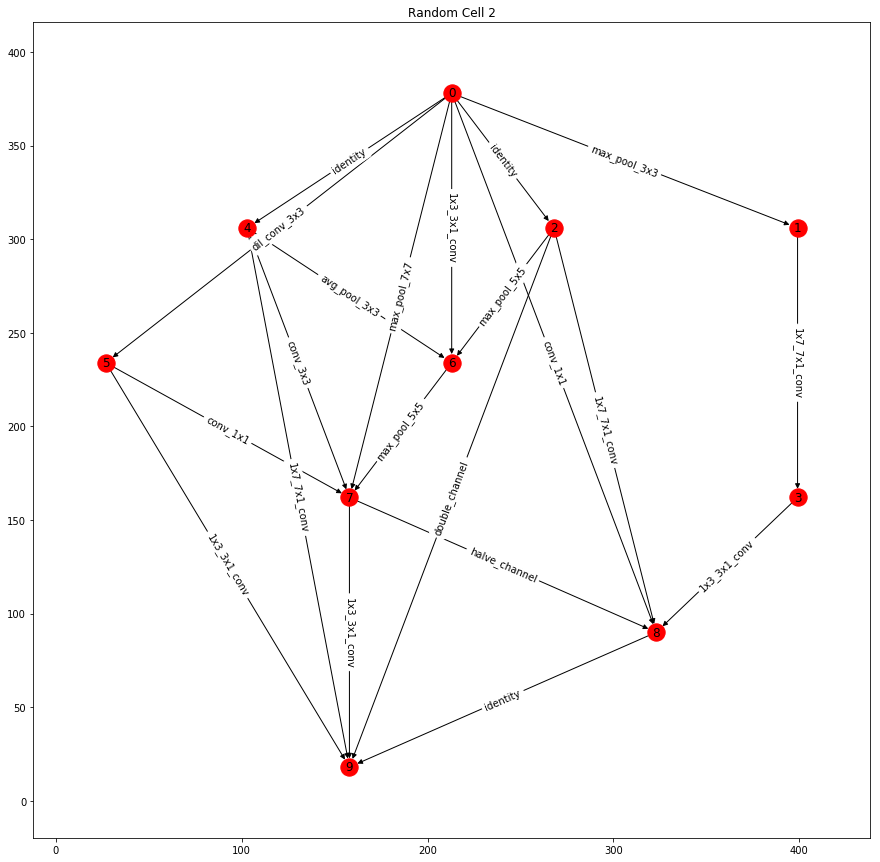

Incorrect scaling ((4.0, 0.5)), skipping


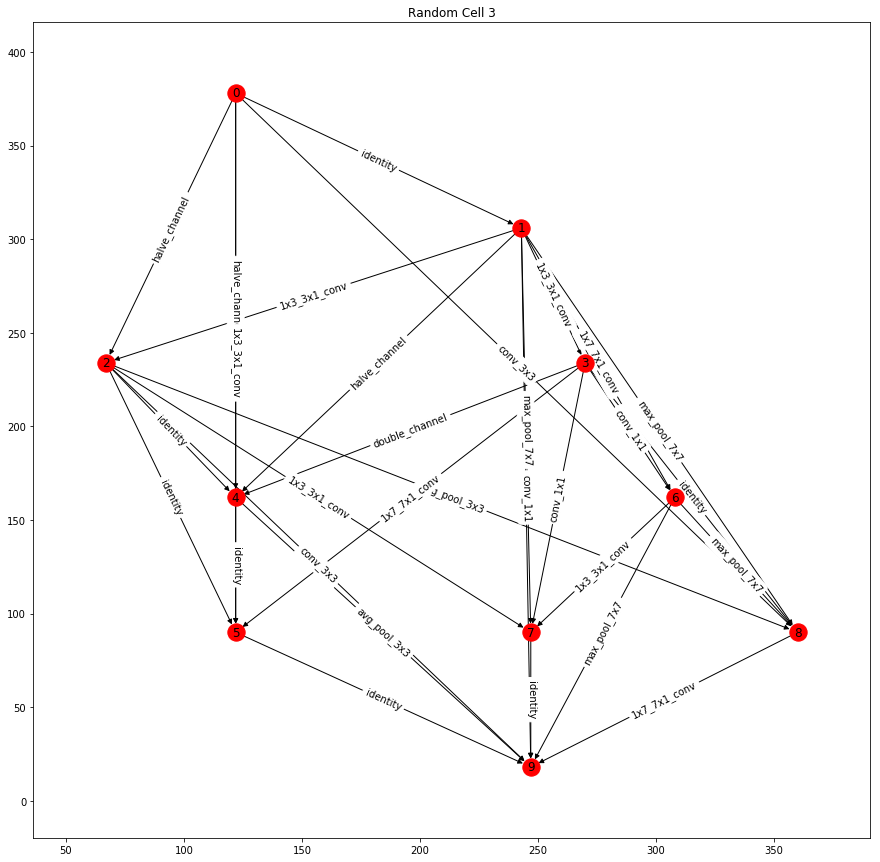

Validating model...[SUCCESS]


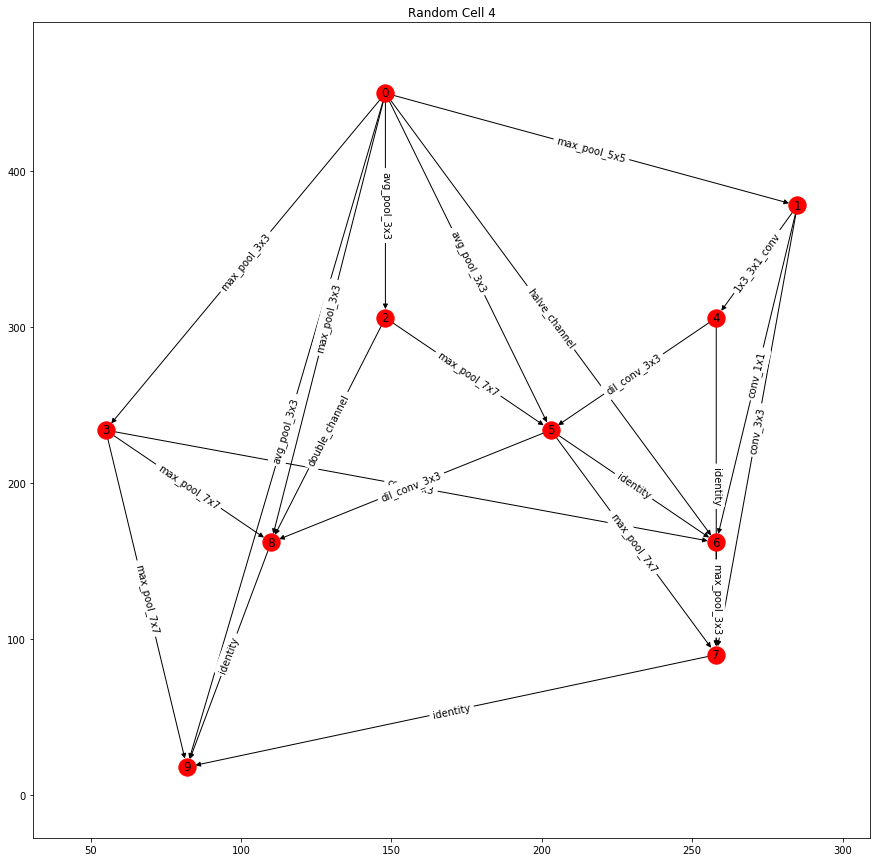

Validating model...[SUCCESS]


In [19]:
for i in range(0,5):
    rand_cell = gen_cell(nodes=10,connectivity=.5)
    show_matrix(rand_cell,"Random Cell {}".format(i))
    p=gen_and_validate(rand_cell,verbose=False,keep_model=False)